In [1]:
from sklearn import tree, metrics
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# load data cleaned from rscript
sc_df = pd.read_csv('../sc_decisions_final.csv', index_col=False)

# fill missing values as they are legitimate
sc_df = sc_df.fillna("N/A")

# remove decision year since unneeded here
sc_df = sc_df.drop(['yearDecision'], axis=1)

print(sc_df.shape)

sc_df.columns

(14047, 23)


Index(['c_chief', 'c_lcDisagreement', 'c_lcDispositionDirection',
       'c_issueArea', 'c_adminActionBool', 'c_oralArgBool', 'c_reargBool',
       'c_decisionTime', 'c_formerCourt', 'c_caseOriginRegion',
       'c_caseOriginCourt', 'e_houseMajority', 'e_senateMajority',
       'e_decisionPresidentParty', 'e_JCApproval', 'j_justiceGender',
       'j_justiceDecisionAgeBand', 'j_justiceRegion', 'j_justiceReligion',
       'j_justiceEthnicity', 'j_justicePresidentParty',
       'j_justiceVotesAppointed', 'direction'],
      dtype='object')

In [2]:
# select non added columns
og_cols = [col for col in sc_df if col.startswith('c_') or col.startswith('direction')]

og_df = sc_df[og_cols]
og_df.shape

(14047, 12)

In [5]:
# select explanatory and response variables
X = og_df.loc[:, og_df.columns != 'direction']
y = og_df[['direction']].astype("category")

# encode target
y = y.apply(lambda x: x.cat.codes)

# check target encoding
# y.apply(lambda x: x.cat.categories) 

# treat booleans and multiple categories differently
cat_vars = list(X.columns[X.nunique() > 2])
bool_vars = list(X.columns[X.nunique() == 2])

# encode categorical features
X_cat = pd.get_dummies(X[cat_vars], columns = cat_vars)
X_bool = pd.get_dummies(X[bool_vars], columns = bool_vars, drop_first = True)
X = pd.concat([X_cat, X_bool], axis = 1)

# split into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
print("Training split input- ", X_train.shape)
print("Testing split input- ", X_test.shape)

Training split input-  (10535, 38)
Testing split input-  (3512, 38)


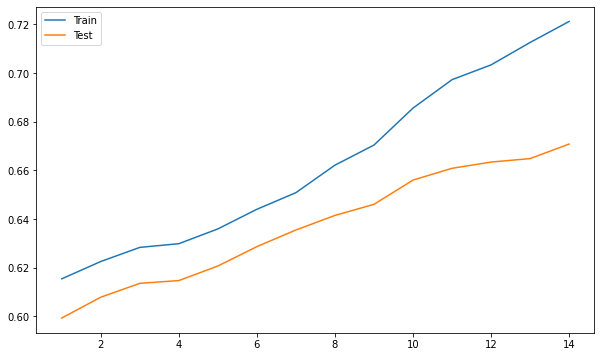

In [6]:
train_scores = []
test_scores = []

# number of trees
depths = [i for i in range(1, 15)] 

# evaluate forest per num trees
for i in depths:
    model = RandomForestClassifier(max_depth=i, n_jobs=-1, random_state = 42)
    model.fit(X_train, np.ravel(y_train))
    
    # evaluate train dataset
    yhat_train = model.predict(X_train)
    train_accuracy = metrics.accuracy_score(y_train, yhat_train)
    train_scores.append(train_accuracy)
    
    # evaluate test dataset
    yhat_test = model.predict(X_test)
    test_accuracy = metrics.accuracy_score(y_test, yhat_test)
    test_scores.append(test_accuracy)


# plot training and test results
plt.figure(figsize=(10,6)) 
plt.plot(depths, train_scores, label='Train')
plt.plot(depths, test_scores, label='Test')
plt.legend()
plt.savefig('validation/og_max_depth_rf.png')

# around 7

In [7]:
# wide range considerations for hyperparameters

# num trees in forest
n_estimators = list(range(100, 1000+1, 100))

# num features to consider at every split
max_features = [5, 15, 20, 25]

# max depth of each tree
max_depth = [7]

# min num samples to split a node
min_samples_split = [2, 5, 10]

# min num samples at each leaf node
min_samples_leaf = [2, 4, 6, 8, 10]

# whether bootstrap samples are used
bootstrap = [True, False]

# random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_features': [5, 15, 20, 25], 'max_depth': [7], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [2, 4, 6, 8, 10], 'bootstrap': [True, False]}


In [8]:
# tune with randomized grid search
model = RandomForestClassifier(random_state = 42)

# random search of parameters with 3 fold CV
model_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 100, cv = 3,
                                  verbose=2, random_state = 42, n_jobs = -1)
# fit the random search model
model_random.fit(X_train, np.ravel(y_train))

model_random.best_params_ # these are narrowed down possible parameter values

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 25,
 'max_depth': 7,
 'bootstrap': True}

In [9]:
 def evaluate(model, x, y):
    y_hat = model.predict(x)
    accuracy = metrics.accuracy_score(y, y_hat)
    return accuracy
    
# evaluate best random model
best_random = model_random.best_estimator_
random_acc = evaluate(best_random, X_test, y_test)
print('best random model test: {:0.2f}%'.format(100 * random_acc))

# base model
base_model = RandomForestClassifier(random_state = 42, max_depth = 7)
base_model.fit(X_train, np.ravel(y_train))
base_acc = evaluate(base_model, X_test, y_test)
print('base model test: {:0.2f}%'.format(100 * base_acc))

print('Improvement of {:0.2f}%'.format(100 * (random_acc - base_acc) / base_acc)) # (new - old)/old

best random model test: 63.95%
base model test: 63.55%
Improvement of 0.63%


In [10]:
# further narrow down values of hyperparameters
# prev random search should be giving us good approximation

# create parameter grid
param_grid = {
    'bootstrap': [True],
    'max_depth': [7], 
    'max_features': [20, 25, 30],
    'min_samples_leaf': [2, 4, 6],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 300, 400]
}

print(param_grid)

{'bootstrap': [True], 'max_depth': [7], 'max_features': [20, 25, 30], 'min_samples_leaf': [2, 4, 6], 'min_samples_split': [2, 5, 10], 'n_estimators': [200, 300, 400]}


In [11]:
# create a new model
model_new = RandomForestClassifier(random_state = 42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = model_new, param_grid = param_grid, cv = 3, 
                           n_jobs = -1, verbose = 2)

# fit grid search to the data
grid_search.fit(X_train, np.ravel(y_train))

grid_search.best_params_

Fitting 3 folds for each of 81 candidates, totalling 243 fits


{'bootstrap': True,
 'max_depth': 7,
 'max_features': 30,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 400}

In [12]:
best_grid = grid_search.best_estimator_
grid_acc = evaluate(best_grid, X_test, y_test)
print('best model test: {:0.2f}%'.format(100 * grid_acc))

print('Improvement of {:0.2f}%.'.format( 100 * (grid_acc - base_acc) / base_acc))

best model test: 64.12%
Improvement of 0.90%.


final model train: 66.26%
final model test: 64.12%


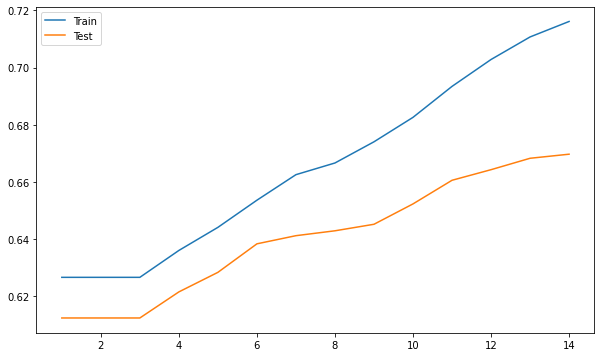

In [13]:
# quick overfitting test check
yhat_train = best_grid.predict(X_train)
train_accuracy = metrics.accuracy_score(y_train, yhat_train)
print('final model train: {:0.2f}%'.format(100 * train_accuracy))

yhat_test = best_grid.predict(X_test)
test_accuracy = metrics.accuracy_score(y_test, yhat_test)
print('final model test: {:0.2f}%'.format(100 * test_accuracy))

# plot
train_scores = []
test_scores = []

# number of trees
depths = [i for i in range(1, 15)] 

# evaluate forest per num trees
for i in depths:
    model = RandomForestClassifier(max_depth=i, n_jobs=-1, random_state = 42, bootstrap = True, max_features = 30, 
                                   min_samples_leaf = 2, min_samples_split = 5, n_estimators = 400)
    model.fit(X_train, np.ravel(y_train))
    
    # evaluate train dataset
    yhat_train = model.predict(X_train)
    train_accuracy = metrics.accuracy_score(y_train, yhat_train)
    train_scores.append(train_accuracy)
    
    # evaluate test dataset
    yhat_test = model.predict(X_test)
    test_accuracy = metrics.accuracy_score(y_test, yhat_test)
    test_scores.append(test_accuracy)


# plot training and test results
plt.figure(figsize=(10,6)) 
plt.plot(depths, train_scores, label='Train')
plt.plot(depths, test_scores, label='Test')
plt.legend()
plt.savefig('validation/og_overfit_rf.png')

# not too bad 

In [14]:
plt.figure(figsize=(200,120)) 
plot_tree(best_grid[0], feature_names = X.columns, 
          class_names =["Conservative", "Liberal"] , filled = True , precision = 4, rounded = True)
plt.savefig('validation/og_first_rf_tree.png')

[CV] END bootstrap=False, max_depth=7, max_features=25, min_samples_leaf=10, min_samples_split=2, n_estimators=900; total time=   6.1s
[CV] END bootstrap=True, max_depth=7, max_features=20, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   1.7s
[CV] END bootstrap=False, max_depth=7, max_features=15, min_samples_leaf=8, min_samples_split=5, n_estimators=600; total time=   2.8s
[CV] END bootstrap=True, max_depth=7, max_features=15, min_samples_leaf=8, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=7, max_features=15, min_samples_leaf=8, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=7, max_features=15, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=7, max_features=25, min_samples_leaf=6, min_samples_split=5, n_estimators=400; total time=   2.0s
[CV] END bootstrap=False, max_depth=7, max_features=15, min_samp

[CV] END bootstrap=True, max_depth=7, max_features=5, min_samples_leaf=8, min_samples_split=5, n_estimators=200; total time=   0.6s
[CV] END bootstrap=True, max_depth=7, max_features=20, min_samples_leaf=10, min_samples_split=5, n_estimators=1000; total time=   4.6s
[CV] END bootstrap=True, max_depth=7, max_features=5, min_samples_leaf=4, min_samples_split=10, n_estimators=900; total time=   2.2s
[CV] END bootstrap=True, max_depth=7, max_features=20, min_samples_leaf=8, min_samples_split=10, n_estimators=200; total time=   0.9s
[CV] END bootstrap=False, max_depth=7, max_features=15, min_samples_leaf=6, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=False, max_depth=7, max_features=15, min_samples_leaf=6, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=7, max_features=5, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=   2.5s
[CV] END bootstrap=True, max_depth=7, max_features=25, min_sample

[CV] END bootstrap=False, max_depth=7, max_features=15, min_samples_leaf=8, min_samples_split=10, n_estimators=600; total time=   3.0s
[CV] END bootstrap=True, max_depth=7, max_features=5, min_samples_leaf=4, min_samples_split=10, n_estimators=900; total time=   2.3s
[CV] END bootstrap=False, max_depth=7, max_features=25, min_samples_leaf=6, min_samples_split=5, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=7, max_features=20, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   1.8s
[CV] END bootstrap=False, max_depth=7, max_features=15, min_samples_leaf=8, min_samples_split=5, n_estimators=600; total time=   2.8s
[CV] END bootstrap=False, max_depth=7, max_features=15, min_samples_leaf=8, min_samples_split=2, n_estimators=1000; total time=   4.6s
[CV] END bootstrap=True, max_depth=7, max_features=20, min_samples_leaf=10, min_samples_split=2, n_estimators=400; total time=   1.8s
[CV] END bootstrap=False, max_depth=7, max_features=5, min_sa

[CV] END bootstrap=True, max_depth=7, max_features=5, min_samples_leaf=8, min_samples_split=5, n_estimators=200; total time=   0.6s
[CV] END bootstrap=True, max_depth=7, max_features=5, min_samples_leaf=8, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, max_depth=7, max_features=20, min_samples_leaf=10, min_samples_split=5, n_estimators=1000; total time=   4.5s
[CV] END bootstrap=False, max_depth=7, max_features=25, min_samples_leaf=6, min_samples_split=5, n_estimators=100; total time=   0.7s
[CV] END bootstrap=False, max_depth=7, max_features=20, min_samples_leaf=6, min_samples_split=5, n_estimators=500; total time=   2.7s
[CV] END bootstrap=True, max_depth=7, max_features=5, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.3s
[CV] END bootstrap=False, max_depth=7, max_features=15, min_samples_leaf=8, min_samples_split=2, n_estimators=1000; total time=   4.7s
[CV] END bootstrap=True, max_depth=7, max_features=20, min_samples

[CV] END bootstrap=False, max_depth=7, max_features=25, min_samples_leaf=10, min_samples_split=2, n_estimators=900; total time=   6.2s
[CV] END bootstrap=False, max_depth=7, max_features=20, min_samples_leaf=6, min_samples_split=5, n_estimators=500; total time=   2.8s
[CV] END bootstrap=True, max_depth=7, max_features=5, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.2s
[CV] END bootstrap=True, max_depth=7, max_features=5, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=   2.5s
[CV] END bootstrap=False, max_depth=7, max_features=15, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=   2.8s
[CV] END bootstrap=True, max_depth=7, max_features=20, min_samples_leaf=6, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=7, max_features=20, min_samples_leaf=6, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=7, max_features=20, min_sampl

final model train: 66.26%
final model test: 64.12%
Tuned Model
              precision    recall  f1-score   support

           0       0.67      0.62      0.64      1815
           1       0.62      0.67      0.64      1697

    accuracy                           0.64      3512
   macro avg       0.64      0.64      0.64      3512
weighted avg       0.64      0.64      0.64      3512



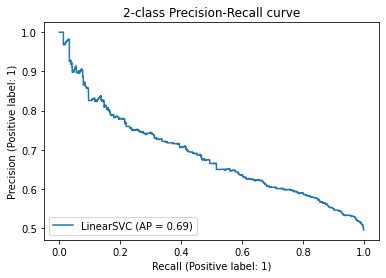

In [15]:
# tuned model (instead of running all of the above)
final_model = RandomForestClassifier(max_depth=7, n_jobs=-1, random_state = 42, bootstrap = True, max_features = 30, 
                                   min_samples_leaf = 2, min_samples_split = 5, n_estimators = 400)
final_model.fit(X_train, np.ravel(y_train))
    
# evaluate train dataset
yhat_train = final_model.predict(X_train)
train_accuracy = metrics.accuracy_score(y_train, yhat_train)
print('final model train: {:0.2f}%'.format(100 * train_accuracy))

# evaluate test dataset
yhat_test = final_model.predict(X_test)
test_accuracy = metrics.accuracy_score(y_test, yhat_test)
print('final model test: {:0.2f}%'.format(100 * test_accuracy))

# other metrics for performance 
print("Tuned Model")
print(metrics.classification_report(y_test, yhat_test))

# precision recall curve
display = metrics.PrecisionRecallDisplay.from_estimator(final_model, X_test, y_test, name="LinearSVC")
_ = display.ax_.set_title("2-class Precision-Recall curve")
plt.savefig('validation/Precision-Recall.png')